In [1]:
import os
import pydicom
import numpy as np
from PIL import Image

# Calea către datele DICOM (input) și PNG (output)
input_root = "dataINbreast"
output_root = "dataOUTbreast"

# Parcurge toate subdirectoarele
for root, dirs, files in os.walk(input_root):
    for file in files:
        if file.lower().endswith(".dcm"):
            input_path = os.path.join(root, file)
            
            # Creează calea de output corespunzătoare
            relative_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, relative_path)
            os.makedirs(output_dir, exist_ok=True)

            # Definește calea finală pentru fișierul PNG
            output_file = os.path.splitext(file)[0] + ".png"
            output_path = os.path.join(output_dir, output_file)

            try:
                # Citește fișierul DICOM
                dicom = pydicom.dcmread(input_path)

                # Obține pixelii
                pixel_array = dicom.pixel_array
                pixel_array = pixel_array.astype(float)
                pixel_array = (np.maximum(pixel_array, 0) / pixel_array.max()) * 255.0
                pixel_array = pixel_array.astype(np.uint8)

                # Creează și salvează imaginea
                image = Image.fromarray(pixel_array)
                image.save(output_path)

                print(f"✔ Salvat: {output_path}")
            except Exception as e:
                print(f"❌ Eroare la {input_path}: {e}")


✔ Salvat: dataOUTbreast\benign_cc\20586908_6c613a14b80a8591_MG_R_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587148_fd746d25eb40b3dc_MG_R_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587174_fd746d25eb40b3dc_MG_L_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587294_e634830794f5c1bd_MG_R_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587320_e634830794f5c1bd_MG_L_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587466_d571b5880ad2a016_MG_L_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587544_d571b5880ad2a016_MG_R_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587638_f4b2d377f43ba0bd_MG_L_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587758_81cd83d2f4d78528_MG_L_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587836_81cd83d2f4d78528_MG_R_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20587902_8dbbd4e51f549ff0_MG_R_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20588020_024ee3569b2605dc_MG_L_CC_ANON.png
✔ Salvat: dataOUTbreast\benign_cc\20588164_8d0b9620c53c0268_MG_R_CC_ANON.png

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Doar clasele dorite
selected_classes = ['benign_mlo', 'malign_mlo']
class_map = {'benign_mlo': 0, 'malign_mlo': 1}

# Transformări
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Custom dataset doar pentru benign_mlo și malign_mlo, cu etichete 0/1
class MLODataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for cls in selected_classes:
            cls_path = os.path.join(root_dir, cls)
            label = class_map[cls]
            for fname in os.listdir(cls_path):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((os.path.join(cls_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label

# Creează dataset-ul
dataset = MLODataset("dataOUTbreast", transform=transform)

# Split train/val
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

print(f"✔ Total imagini MLO: {len(dataset)} (Benign: 0, Malign: 1)")



✔ Total imagini MLO: 206 (Benign: 0, Malign: 1)


In [4]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2  # benign / malign
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

C:\AI\Incercare proiect AI\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\magui\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import torch
from torch.optim import AdamW
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
class_weights = torch.tensor([1.0, 166 / 40], dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(pixel_values=images)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Loss": f"{running_loss / total:.4f}",
            "Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Loss = {running_loss / total:.4f}, Accuracy = {(correct / total) * 100:.2f}%")

output_dir = "vit_mamografie_model_entropy_1"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
print(f"✔ Modelul a fost salvat în: {output_dir}")


Epoch 1/5: 100%|██████████| 11/11 [03:36<00:00, 19.68s/it, Loss=0.0315, Acc=87.80%]


✅ Epoch 1: Loss = 0.0315, Accuracy = 87.80%


Epoch 2/5: 100%|██████████| 11/11 [04:24<00:00, 24.09s/it, Loss=0.0224, Acc=96.95%]


✅ Epoch 2: Loss = 0.0224, Accuracy = 96.95%


Epoch 3/5: 100%|██████████| 11/11 [03:39<00:00, 19.92s/it, Loss=0.0155, Acc=100.00%]


✅ Epoch 3: Loss = 0.0155, Accuracy = 100.00%


Epoch 4/5: 100%|██████████| 11/11 [03:48<00:00, 20.77s/it, Loss=0.0123, Acc=100.00%]


✅ Epoch 4: Loss = 0.0123, Accuracy = 100.00%


Epoch 5/5: 100%|██████████| 11/11 [03:36<00:00, 19.65s/it, Loss=0.0094, Acc=100.00%]


✅ Epoch 5: Loss = 0.0094, Accuracy = 100.00%
✔ Modelul a fost salvat în: vit_mamografie_model_entropy_1


In [12]:
from transformers import ViTForImageClassification
import torch

# Încarcă modelul salvat corect
model = ViTForImageClassification.from_pretrained("vit_mamografie_model_entropy_1")

# Trimite pe GPU dacă există
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_dataset = datasets.ImageFolder("validare_mlo", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(pixel_values=images)
        _, preds = torch.max(outputs.logits, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("📊 Raport clasificare pe validare:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


📊 Raport clasificare pe validare:
              precision    recall  f1-score   support

      Benign       0.78      0.55      0.64        33
      Malign       0.17      0.38      0.23         8

    accuracy                           0.51        41
   macro avg       0.47      0.46      0.44        41
weighted avg       0.66      0.51      0.56        41

🧾 Confusion Matrix:
[[18 15]
 [ 5  3]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(pixel_values=images)
        preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=dataset.classes))


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
from transformers import ViTForImageClassification
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

# ============================
# 🔧 CONFIG
# ============================
train_dir = "databreast"
val_dir = "validare_mlo"
batch_size = 16
num_epochs = 10
early_stop_patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 📦 TRANSFORMĂRI
# ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ============================
# 📥 ÎNCĂRCARE DATE
# ============================
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ============================
# 🧠 MODEL
# ============================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2  # benign / malign
)
model.to(device)

# ============================
# ⚖️ LOSS + OPTIMIZER
# ============================
# Pondere pentru clasa minoritară (malign = 40)
class_weights = torch.tensor([1.0, 166 / 40], dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-5)

# ============================
# 🚦 TRAIN + VALIDARE + EARLY STOPPING
# ============================
best_f1 = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Train_Loss": f"{running_loss / total:.4f}",
            "Train_Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Train Loss = {running_loss / total:.4f}, Accuracy = {(correct / total) * 100:.2f}%")

    # VALIDARE
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(pixel_values=images)
            _, preds = torch.max(outputs.logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred)
    print(f"🧪 Validation F1-score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))

    # EARLY STOPPING
    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        output_dir = "vit_mamografie_best_model"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        print(f"💾 Model salvat (F1 = {f1:.4f}) în: {output_dir}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⏹️ Early stopping activat. F1 maxim: {best_f1:.4f}")
            break


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 13/13 [03:01<00:00, 13.97s/it, Train_Loss=0.0442, Train_Acc=78.16%]


✅ Epoch 1: Train Loss = 0.0442, Accuracy = 78.16%
🧪 Validation F1-score: 0.0000
              precision    recall  f1-score   support

      Benign       0.78      0.88      0.83        33
      Malign       0.00      0.00      0.00         8

    accuracy                           0.71        41
   macro avg       0.39      0.44      0.41        41
weighted avg       0.63      0.71      0.67        41


Epoch 2/10: 100%|██████████| 13/13 [02:38<00:00, 12.17s/it, Train_Loss=0.0439, Train_Acc=46.60%]


✅ Epoch 2: Train Loss = 0.0439, Accuracy = 46.60%
🧪 Validation F1-score: 0.0000
              precision    recall  f1-score   support

      Benign       0.79      0.91      0.85        33
      Malign       0.00      0.00      0.00         8

    accuracy                           0.73        41
   macro avg       0.39      0.45      0.42        41
weighted avg       0.64      0.73      0.68        41


Epoch 3/10: 100%|██████████| 13/13 [02:39<00:00, 12.25s/it, Train_Loss=0.0412, Train_Acc=81.07%]


✅ Epoch 3: Train Loss = 0.0412, Accuracy = 81.07%
🧪 Validation F1-score: 0.1818
              precision    recall  f1-score   support

      Benign       0.82      0.94      0.87        33
      Malign       0.33      0.12      0.18         8

    accuracy                           0.78        41
   macro avg       0.57      0.53      0.53        41
weighted avg       0.72      0.78      0.74        41

💾 Model salvat (F1 = 0.1818) în: vit_mamografie_best_model


Epoch 4/10: 100%|██████████| 13/13 [02:37<00:00, 12.13s/it, Train_Loss=0.0387, Train_Acc=83.50%]


✅ Epoch 4: Train Loss = 0.0387, Accuracy = 83.50%
🧪 Validation F1-score: 0.1667
              precision    recall  f1-score   support

      Benign       0.81      0.91      0.86        33
      Malign       0.25      0.12      0.17         8

    accuracy                           0.76        41
   macro avg       0.53      0.52      0.51        41
weighted avg       0.70      0.76      0.72        41


Epoch 5/10: 100%|██████████| 13/13 [02:35<00:00, 11.96s/it, Train_Loss=0.0348, Train_Acc=89.81%]


✅ Epoch 5: Train Loss = 0.0348, Accuracy = 89.81%
🧪 Validation F1-score: 0.2667
              precision    recall  f1-score   support

      Benign       0.79      0.45      0.58        33
      Malign       0.18      0.50      0.27         8

    accuracy                           0.46        41
   macro avg       0.49      0.48      0.42        41
weighted avg       0.67      0.46      0.52        41

💾 Model salvat (F1 = 0.2667) în: vit_mamografie_best_model


Epoch 6/10:  31%|███       | 4/13 [00:54<02:01, 13.54s/it, Train_Loss=0.0270, Train_Acc=95.31%]

PRIMA EPOCA DOAR MALIGNE

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from torch.optim import AdamW
from transformers import ViTForImageClassification
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

# ============================
# 🔧 CONFIG
# ============================
train_dir = "model"       # conține benign_mlo și malign_mlo
val_dir = "validare"      # conține benign_mlo și malign_mlo
batch_size = 16
num_epochs = 10
early_stop_patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 📦 TRANSFORMĂRI
# ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

# ============================
# 📥 ÎNCĂRCARE DATE + SAMPLER
# ============================
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)
print(train_dataset.class_to_idx)
# sampler pentru echilibrare clase
targets = train_dataset.targets
class_count = [targets.count(0), targets.count(1)]
weights = [1.0 / c for c in class_count]
samples_weight = [weights[t] for t in targets]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ============================
# 🧠 MODEL
# ============================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
model.to(device)

# ============================
# ⚖️ LOSS + OPTIMIZER
# ============================
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, class_count[0]/class_count[1]]).to(device))
optimizer = AdamW(model.parameters(), lr=2e-5)

# ============================
# 🚦 TRAIN + VALIDARE
# ============================
best_f1 = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Train_Loss": f"{running_loss / total:.4f}",
            "Train_Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Train Loss = {running_loss / total:.4f}, Accuracy = {(correct / total) * 100:.2f}%")

    # VALIDARE
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            _, preds = torch.max(outputs.logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred)
    print(f"🧪 Validation F1-score: {f1:.4f}")

    # Salvează raportul de clasificare
    report = classification_report(y_true, y_pred, target_names=["Benign", "Malign"])
    print(report)
    report_path = f"classification_report_epoch{epoch+1}.txt"
    with open(report_path, "w") as f:
        f.write(report)
    print(f"📄 Raport salvat în: {report_path}")

    # Matrice de confuzie
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malign"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.savefig(f"conf_matrix_epoch{epoch+1}.png")
    plt.close()
    print(f"🖼️ Matrice de confuzie salvată în: conf_matrix_epoch{epoch+1}.png")

    # EARLY STOPPING
    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        output_dir = f"vit_mamografie_5_24_2025_model1{epoch+1}_f1{f1:.4f}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        print(f"💾 Model salvat în: {output_dir}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⏹️ Early stopping activat. F1 maxim: {best_f1:.4f}")
            break


{'benign_mlo': 0, 'malign_mlo': 1}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 27/27 [06:14<00:00, 13.86s/it, Train_Loss=0.0331, Train_Acc=51.18%]


✅ Epoch 1: Train Loss = 0.0331, Accuracy = 51.18%
🧪 Validation F1-score: 0.2903
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        88
      Malign       0.17      1.00      0.29        18

    accuracy                           0.17       106
   macro avg       0.08      0.50      0.15       106
weighted avg       0.03      0.17      0.05       106

📄 Raport salvat în: classification_report_epoch1.txt
🖼️ Matrice de confuzie salvată în: conf_matrix_epoch1.png


C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 Model salvat în: vit_mamografie_5_24_2025_model11_f10.2903


Epoch 2/10:  48%|████▊     | 13/27 [11:39<42:13, 180.94s/it, Train_Loss=0.0295, Train_Acc=49.52%]

FOARTE PROST MODEL ___________ASA NU

In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
from transformers import ViTForImageClassification
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

# ============================
# 🔧 CONFIG
# ============================
train_dir = "model"       # conține benign_mlo și malign_mlo
val_dir = "validare"      # conține benign_mlo și malign_mlo
batch_size = 16
num_epochs = 10
early_stop_patience = 5
min_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 📦 TRANSFORMĂRI
# ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

# ============================
# 📥 ÎNCĂRCARE DATE
# ============================
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)
print("Etichete clase:", train_dataset.class_to_idx)

# distribuție clase pentru ponderare loss
targets = train_dataset.targets
class_count = [targets.count(0), targets.count(1)]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ============================
# 🧠 MODEL
# ============================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
model.to(device)

# ============================
# ⚖️ LOSS + OPTIMIZER
# ============================
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, class_count[0]/class_count[1]]).to(device))
optimizer = AdamW(model.parameters(), lr=2e-5)

# ============================
# 🚦 TRAIN + VALIDARE
# ============================
best_f1 = 0
epochs_no_improve = 0
best_model_state = None
best_y_true = []
best_y_pred = []
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Train_Loss": f"{running_loss / total:.4f}",
            "Train_Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Train Loss = {running_loss / total:.4f}, Accuracy = {(correct / total) * 100:.2f}%")

    # VALIDARE
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            _, preds = torch.max(outputs.logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred)
    print(f"🧪 Validation F1-score: {f1:.4f}")

    # Salvează cel mai bun model în memorie
    if f1 > best_f1:
        best_f1 = f1
        best_y_true = y_true.copy()
        best_y_pred = y_pred.copy()
        best_model_state = model.state_dict()
        best_epoch = epoch + 1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epoch + 1 >= min_epochs and epochs_no_improve >= early_stop_patience:
            print(f"⏹️ Early stopping activat. F1 maxim: {best_f1:.4f}")
            break

# ============================
# ✅ SALVARE FINALĂ
# ============================
final_dir = f"vit_mamografie_5_24_2025_model1_best_epoch{best_epoch}_f1{best_f1:.4f}"
os.makedirs(final_dir, exist_ok=True)

model.load_state_dict(best_model_state)
model.save_pretrained(final_dir)
print(f"💾 Modelul cu performanța cea mai bună a fost salvat în: {final_dir}")

# Raport + Matrice Confuzie
report = classification_report(best_y_true, best_y_pred, target_names=["Benign", "Malign"], zero_division=0)
with open(os.path.join(final_dir, "classification_report.txt"), "w") as f:
    f.write(report)
print(f"📄 Raport final salvat în: {final_dir}/classification_report.txt")

cm = confusion_matrix(best_y_true, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malign"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - Best Epoch {best_epoch}")
plt.savefig(os.path.join(final_dir, "conf_matrix.png"))
plt.close()
print(f"🖼️ Matrice de confuzie finală salvată în: {final_dir}/conf_matrix.png")


Etichete clase: {'benign_mlo': 0, 'malign_mlo': 1}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 27/27 [05:19<00:00, 11.85s/it, Train_Loss=0.0442, Train_Acc=74.41%]


✅ Epoch 1: Train Loss = 0.0442, Accuracy = 74.41%
🧪 Validation F1-score: 0.0000


Epoch 2/10: 100%|██████████| 27/27 [07:07<00:00, 15.83s/it, Train_Loss=0.0423, Train_Acc=71.56%]


✅ Epoch 2: Train Loss = 0.0423, Accuracy = 71.56%
🧪 Validation F1-score: 0.0000


Epoch 3/10:   0%|          | 0/27 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import torch
from torch.optim import AdamW
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
class_weights = torch.tensor([1.0, 166 / 40], dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(pixel_values=images)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Loss": f"{running_loss / total:.4f}",
            "Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Loss = {running_loss / total:.4f}, Accuracy = {(correct / total) * 100:.2f}%")

output_dir = "vit_mamografie_model_24mai"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
print(f"✔ Modelul a fost salvat în: {output_dir}")


In [2]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from torch.optim import AdamW
from transformers import ViTForImageClassification
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

# ============================
# 🔧 CONFIG
# ============================
train_dir = "model"       # conține benign_mlo și malign_mlo
val_dir = "validare"      # conține benign_mlo și malign_mlo
batch_size = 16
num_epochs = 10
early_stop_patience = 5
min_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 📦 TRANSFORMĂRI
# ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

# ============================
# 📥 ÎNCĂRCARE DATE + SAMPLER
# ============================
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)

print("Etichete clase:", train_dataset.class_to_idx)  # {'benign_mlo': 0, 'malign_mlo': 1}

targets = train_dataset.targets
class_counts = [targets.count(0), targets.count(1)]

# Greutăți ajustate (mai blânde decât inversul frecvenței)
weights = [1.0 / class_counts[0], 2.5 / class_counts[1]]
samples_weight = [weights[t] for t in targets]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ============================
# 🧠 MODEL
# ============================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
model.to(device)

# ============================
# ⚖️ LOSS + OPTIMIZER
# ============================
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.5]).to(device))
optimizer = AdamW(model.parameters(), lr=2e-5)

# ============================
# 🚦 TRAIN + VALIDARE
# ============================
best_f1 = 0
epochs_no_improve = 0
best_model_state = None
best_y_true = []
best_y_pred = []
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Train_Loss": f"{running_loss / total:.4f}",
            "Train_Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Train Loss = {running_loss / total:.4f}, Accuracy = {(correct / total) * 100:.2f}%")

    # VALIDARE
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            _, preds = torch.max(outputs.logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred)
    print(f"🧪 Validation F1-score: {f1:.4f}")
    print("🟨 Predicții val:", torch.tensor(y_pred).bincount().tolist())
    print("🟦 Etichete reale:", torch.tensor(y_true).bincount().tolist())

    if f1 > best_f1:
        best_f1 = f1
        best_y_true = y_true.copy()
        best_y_pred = y_pred.copy()
        best_model_state = model.state_dict()
        best_epoch = epoch + 1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epoch + 1 >= min_epochs and epochs_no_improve >= early_stop_patience:
            print(f"⏹️ Early stopping activat. F1 maxim: {best_f1:.4f}")
            break

# ============================
# ✅ SALVARE FINALĂ
# ============================
final_dir = f"vit_mamografie_5_24_2025_model1_best_epoch{best_epoch}_f1{best_f1:.4f}"
os.makedirs(final_dir, exist_ok=True)

model.load_state_dict(best_model_state)
model.save_pretrained(final_dir)
print(f"💾 Modelul cu performanța cea mai bună a fost salvat în: {final_dir}")

report = classification_report(best_y_true, best_y_pred, target_names=["Benign", "Malign"], zero_division=0)
with open(os.path.join(final_dir, "classification_report.txt"), "w") as f:
    f.write(report)
print(f"📄 Raport final salvat în: {final_dir}/classification_report.txt")

cm = confusion_matrix(best_y_true, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malign"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - Best Epoch {best_epoch}")
plt.savefig(os.path.join(final_dir, "conf_matrix.png"))
plt.close()
print(f"🖼️ Matrice de confuzie finală salvată în: {final_dir}/conf_matrix.png")


Etichete clase: {'benign_mlo': 0, 'malign_mlo': 1}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 27/27 [05:10<00:00, 11.52s/it, Train_Loss=0.0285, Train_Acc=73.46%]


✅ Epoch 1: Train Loss = 0.0285, Accuracy = 73.46%
🧪 Validation F1-score: 0.2903
🟨 Predicții val: [0, 106]
🟦 Etichete reale: [88, 18]


Epoch 2/10: 100%|██████████| 27/27 [05:06<00:00, 11.34s/it, Train_Loss=0.0229, Train_Acc=74.17%]


✅ Epoch 2: Train Loss = 0.0229, Accuracy = 74.17%
🧪 Validation F1-score: 0.2903
🟨 Predicții val: [0, 106]
🟦 Etichete reale: [88, 18]


Epoch 3/10: 100%|██████████| 27/27 [08:16<00:00, 18.39s/it, Train_Loss=0.0196, Train_Acc=73.93%]


✅ Epoch 3: Train Loss = 0.0196, Accuracy = 73.93%
🧪 Validation F1-score: 0.2903
🟨 Predicții val: [0, 106]
🟦 Etichete reale: [88, 18]


Epoch 4/10:   0%|          | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002AE07B8B100>
Traceback (most recent call last):
  File "C:\AI\Incercare proiect AI\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "C:\AI\Incercare proiect AI\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\magui\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\magui\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\popen_spawn_win32.py", line 109, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 
Epoch 4/10:   0%|          | 0/27 [00:11<?, 

KeyboardInterrupt: 

In [20]:
from PIL import Image
import os

def convert_and_resize_all_images(folder_path, delete_original=False, target_size=(224, 224)):
    supported = [".png", ".pgm", ".jpeg", ".jpg"]
    for root, _, files in os.walk(folder_path):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext in supported:
                full_path = os.path.join(root, file)
                new_path = os.path.splitext(full_path)[0] + ".jpg"
                try:
                    img = Image.open(full_path).convert("RGB").resize(target_size)
                    img.save(new_path, "JPEG", quality=95)
                    print(f"✅ Convertit și redimensionat: {file} → {os.path.basename(new_path)}")
                    if delete_original and full_path != new_path:
                        os.remove(full_path)
                        print(f"🗑️ Șters: {file}")
                except Exception as e:
                    print(f"⚠️ Eroare la {file}: {e}")

convert_and_resize_all_images("model/")
convert_and_resize_all_images("validare/")


✅ Convertit și redimensionat: 20586960_6c613a14b80a8591_MG_R_ML_ANON.jpg → 20586960_6c613a14b80a8591_MG_R_ML_ANON.jpg
✅ Convertit și redimensionat: 20587200_fd746d25eb40b3dc_MG_R_ML_ANON.jpg → 20587200_fd746d25eb40b3dc_MG_R_ML_ANON.jpg
✅ Convertit și redimensionat: 20587226_fd746d25eb40b3dc_MG_L_ML_ANON.jpg → 20587226_fd746d25eb40b3dc_MG_L_ML_ANON.jpg
✅ Convertit și redimensionat: 20587346_e634830794f5c1bd_MG_R_ML_ANON.jpg → 20587346_e634830794f5c1bd_MG_R_ML_ANON.jpg
✅ Convertit și redimensionat: 20587372_e634830794f5c1bd_MG_L_ML_ANON.jpg → 20587372_e634830794f5c1bd_MG_L_ML_ANON.jpg
✅ Convertit și redimensionat: 20587492_d571b5880ad2a016_MG_R_ML_ANON.jpg → 20587492_d571b5880ad2a016_MG_R_ML_ANON.jpg
✅ Convertit și redimensionat: 20587518_d571b5880ad2a016_MG_L_ML_ANON.jpg → 20587518_d571b5880ad2a016_MG_L_ML_ANON.jpg
✅ Convertit și redimensionat: 20587690_f4b2d377f43ba0bd_MG_L_ML_ANON.jpg → 20587690_f4b2d377f43ba0bd_MG_L_ML_ANON.jpg
✅ Convertit și redimensionat: 20587784_81cd83d2f4d78528_

In [17]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
from transformers import ViTForImageClassification
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

# ============================
# 🔧 CONFIG
# ============================
train_dir = "model"
val_dir = "validare"
batch_size = 16
num_epochs = 10
early_stop_patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 📦 TRANSFORMĂRI
# ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ============================
# 📥 ÎNCĂRCARE DATE
# ============================
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ============================
# 🧠 MODEL
# ============================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2  # benign / malign
)
model.to(device)

# ============================
# ⚖️ LOSS + OPTIMIZER
# ============================

class_weights = torch.tensor([1.0, 1.0], dtype=torch.float).to(device) 
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-5)

# ============================
# 🚦 TRAIN + VALIDARE + EARLY STOPPING
# ============================
best_f1 = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Train_Loss": f"{running_loss / total:.4f}",
            "Train_Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Train Loss = {running_loss / total:.4f}, Accuracy = {(correct / total) * 100:.2f}%")

    # VALIDARE
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(pixel_values=images)
            _, preds = torch.max(outputs.logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred)
    print(f"🧪 Validation F1-score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))

    # EARLY STOPPING
    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        output_dir = "vit_mamografie_best_model_24mai"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        print(f"💾 Model salvat (F1 = {f1:.4f}) în: {output_dir}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⏹️ Early stopping activat. F1 maxim: {best_f1:.4f}")
            break


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 27/27 [04:38<00:00, 10.32s/it, Train_Loss=0.0335, Train_Acc=78.30%]


✅ Epoch 1: Train Loss = 0.0335, Accuracy = 78.30%


C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🧪 Validation F1-score: 0.0000
              precision    recall  f1-score   support

      Benign       0.74      1.00      0.85        88
      Malign       0.00      0.00      0.00        31

    accuracy                           0.74       119
   macro avg       0.37      0.50      0.43       119
weighted avg       0.55      0.74      0.63       119


Epoch 2/10:  15%|█▍        | 4/27 [01:11<06:52, 17.95s/it, Train_Loss=0.0290, Train_Acc=81.25%]


KeyboardInterrupt: 

In [18]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
from transformers import ViTForImageClassification
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

# ============================
# 🔧 CONFIG
# ============================
train_dir = "model"
val_dir = "validare"
batch_size = 16
num_epochs = 10
early_stop_patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 📦 TRANSFORMĂRI
# ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ============================
# 📥 ÎNCĂRCARE DATE
# ============================
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ============================
# 🧠 MODEL
# ============================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2  # benign / malign
)
model.to(device)

# ============================
# ⚖️ LOSS + OPTIMIZER
# ============================
# Pondere pentru clasa minoritară (malign = 40)
class_weights = torch.tensor([1.0, 166 / 40], dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-5)

# ============================
# 🚦 TRAIN + VALIDARE + EARLY STOPPING
# ============================
best_f1 = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Train_Loss": f"{running_loss / total:.4f}",
            "Train_Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Train Loss = {running_loss / total:.4f}, Accuracy = {(correct / total) * 100:.2f}%")

    # VALIDARE
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(pixel_values=images)
            _, preds = torch.max(outputs.logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred)
    print(f"🧪 Validation F1-score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))

    # EARLY STOPPING
    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        output_dir = "vit_mamografie_24mai"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        print(f"💾 Model salvat (F1 = {f1:.4f}) în: {output_dir}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⏹️ Early stopping activat. F1 maxim: {best_f1:.4f}")
            break


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 27/27 [05:30<00:00, 12.23s/it, Train_Loss=0.0441, Train_Acc=71.46%]


✅ Epoch 1: Train Loss = 0.0441, Accuracy = 71.46%


C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🧪 Validation F1-score: 0.0000
              precision    recall  f1-score   support

      Benign       0.74      1.00      0.85        88
      Malign       0.00      0.00      0.00        31

    accuracy                           0.74       119
   macro avg       0.37      0.50      0.43       119
weighted avg       0.55      0.74      0.63       119


Epoch 2/10:   0%|          | 0/27 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [21]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
from collections import Counter

# ============================ 🔧 CONFIG ============================
train_dir = "model"
val_dir = "validare"
batch_size = 16
num_epochs = 10
early_stop_patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================ 📦 TRANSFORMĂRI ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ============================ 📥 ÎNCĂRCARE DATE ============================
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)

targets = train_dataset.targets
class_counts = [targets.count(0), targets.count(1)]
print("Distribuție clase train:", class_counts)

# Ponderi invers proporționale pentru sampler
weights = [1.0 / class_counts[t] for t in targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ============================ 🧠 MODEL ============================
model = models.resnet50(pretrained=True)

# Înlocuim ultimul fully-connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.to(device)

# ============================ ⚖️ LOSS + OPTIM ============================
# Pondere pentru clasa malign
class_weights = torch.tensor([1.0, class_counts[0] / class_counts[1]], dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=1e-4)

# ============================ 🚦 TRAIN + VALIDARE ============================
best_f1 = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Loss": f"{running_loss / total:.4f}",
            "Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Loss = {running_loss / total:.4f}, Acc = {(correct / total) * 100:.2f}%")

    # VALIDARE
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred)
    print(f"🧪 F1-score: {f1:.4f}")
    print("🎯 Etichete reale:", Counter(y_true))
    print("📊 Predicții:", Counter(y_pred))
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))

    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        output_dir = "resnet50_mamografie_best"
        os.makedirs(output_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(output_dir, "model.pt"))
        print(f"💾 Model salvat în: {output_dir}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⏹️ Early stopping activat. F1 maxim: {best_f1:.4f}")
            break


Distribuție clase train: [348, 123]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\magui/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:14<00:00, 7.10MB/s]
Epoch 1/10: 100%|██████████| 30/30 [01:38<00:00,  3.29s/it, Loss=0.0318, Acc=60.30%]


✅ Epoch 1: Loss = 0.0318, Acc = 60.30%
🧪 F1-score: 0.5000
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 94, np.int64(1): 25})
              precision    recall  f1-score   support

      Benign       0.82      0.88      0.85        88
      Malign       0.56      0.45      0.50        31

    accuracy                           0.76       119
   macro avg       0.69      0.66      0.67       119
weighted avg       0.75      0.76      0.76       119

💾 Model salvat în: resnet50_mamografie_best


Epoch 2/10: 100%|██████████| 30/30 [03:05<00:00,  6.17s/it, Loss=0.0307, Acc=60.93%]


✅ Epoch 2: Loss = 0.0307, Acc = 60.93%
🧪 F1-score: 0.4301
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 62, np.int64(0): 57})
              precision    recall  f1-score   support

      Benign       0.81      0.52      0.63        88
      Malign       0.32      0.65      0.43        31

    accuracy                           0.55       119
   macro avg       0.56      0.58      0.53       119
weighted avg       0.68      0.55      0.58       119


Epoch 3/10: 100%|██████████| 30/30 [02:31<00:00,  5.04s/it, Loss=0.0261, Acc=72.82%]


✅ Epoch 3: Loss = 0.0261, Acc = 72.82%
🧪 F1-score: 0.4113
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 110, np.int64(0): 9})
              precision    recall  f1-score   support

      Benign       0.78      0.08      0.14        88
      Malign       0.26      0.94      0.41        31

    accuracy                           0.30       119
   macro avg       0.52      0.51      0.28       119
weighted avg       0.64      0.30      0.21       119


Epoch 4/10: 100%|██████████| 30/30 [03:55<00:00,  7.86s/it, Loss=0.0216, Acc=78.34%]


✅ Epoch 4: Loss = 0.0216, Acc = 78.34%
🧪 F1-score: 0.5957
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 103, np.int64(1): 16})
              precision    recall  f1-score   support

      Benign       0.83      0.98      0.90        88
      Malign       0.88      0.45      0.60        31

    accuracy                           0.84       119
   macro avg       0.85      0.71      0.75       119
weighted avg       0.85      0.84      0.82       119

💾 Model salvat în: resnet50_mamografie_best


Epoch 5/10: 100%|██████████| 30/30 [03:10<00:00,  6.37s/it, Loss=0.0249, Acc=76.22%]


✅ Epoch 5: Loss = 0.0249, Acc = 76.22%
🧪 F1-score: 0.5532
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 103, np.int64(1): 16})
              precision    recall  f1-score   support

      Benign       0.83      0.97      0.89        88
      Malign       0.81      0.42      0.55        31

    accuracy                           0.82       119
   macro avg       0.82      0.69      0.72       119
weighted avg       0.82      0.82      0.80       119


Epoch 6/10: 100%|██████████| 30/30 [03:39<00:00,  7.33s/it, Loss=0.0179, Acc=83.23%]


✅ Epoch 6: Loss = 0.0179, Acc = 83.23%
🧪 F1-score: 0.5246
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 89, np.int64(1): 30})
              precision    recall  f1-score   support

      Benign       0.83      0.84      0.84        88
      Malign       0.53      0.52      0.52        31

    accuracy                           0.76       119
   macro avg       0.68      0.68      0.68       119
weighted avg       0.75      0.76      0.75       119


Epoch 7/10: 100%|██████████| 30/30 [03:24<00:00,  6.81s/it, Loss=0.0127, Acc=89.60%]


✅ Epoch 7: Loss = 0.0127, Acc = 89.60%
🧪 F1-score: 0.4384
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 77, np.int64(1): 42})
              precision    recall  f1-score   support

      Benign       0.81      0.70      0.75        88
      Malign       0.38      0.52      0.44        31

    accuracy                           0.66       119
   macro avg       0.59      0.61      0.59       119
weighted avg       0.69      0.66      0.67       119

⏹️ Early stopping activat. F1 maxim: 0.5957


In [22]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm
from collections import Counter
import csv

# ---------------------CONFIG-----------------------
train_dir = "model"
val_dir = "validare"
batch_size = 16
num_epochs = 10
early_stop_patience = 3
threshold = 0.3  #prag
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#-------------------TRANSFORMARI----------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#------------------------DATE----------------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)

targets = train_dataset.targets
class_counts = [targets.count(0), targets.count(1)]
print("Distributie clase train:", class_counts)

weights = [1.0 / class_counts[t] for t in targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#------------------------MODEL--------------------------------
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=2.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return loss.mean()

loss_fn = FocalLoss(alpha=2.0, gamma=2.0)
optimizer = AdamW(model.parameters(), lr=1e-4)
#---------------------------TRAIN-------------------------
best_recall = 0
epochs_no_improve = 0

with open("fisier_log.csv", mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Epoch", "Precision", "Recall", "F1"])

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix({
                "Loss": f"{running_loss / total:.4f}",
                "Acc": f"{(correct / total) * 100:.2f}%"
            })

        print(f"Epoch {epoch+1}: Train Loss = {running_loss / total:.4f}")

        #---------------------VALIDARE--------------------------
        model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                probs = torch.softmax(outputs, dim=1)[:, 1]  # probabilitate malign
                preds = (probs > threshold).long()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print(f"Epoch {epoch+1} → Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        print("Etichete reale:", Counter(y_true))
        print("Predictii:", Counter(y_pred))
        print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))

        writer.writerow([epoch+1, precision, recall, f1])

        # Early stopping
        if recall > best_recall:
            best_recall = recall
            epochs_no_improve = 0
            output_dir = "resnet50_mamografie_model"
            os.makedirs(output_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(output_dir, "model.pt"))
            print(f"Model salvat in: {output_dir}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping activat. Recall maxim: {best_recall:.4f}")
                break


📊 Distribuție clase train: [348, 123]


C:\AI\Incercare proiect AI\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 30/30 [01:46<00:00,  3.55s/it, Loss=0.0196, Acc=68.58%]


✅ Epoch 1: Train Loss = 0.0196
🧪 Epoch 1 → Precision: 0.4000 | Recall: 0.5161 | F1: 0.4507
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 79, np.int64(1): 40})
              precision    recall  f1-score   support

      Benign       0.81      0.73      0.77        88
      Malign       0.40      0.52      0.45        31

    accuracy                           0.67       119
   macro avg       0.61      0.62      0.61       119
weighted avg       0.70      0.67      0.68       119

💾 Model salvat în: resnet50_focus_recall_best


Epoch 2/10: 100%|██████████| 30/30 [01:36<00:00,  3.21s/it, Loss=0.0151, Acc=79.83%]


✅ Epoch 2: Train Loss = 0.0151
🧪 Epoch 2 → Precision: 0.2632 | Recall: 0.9677 | F1: 0.4138
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 114, np.int64(0): 5})
              precision    recall  f1-score   support

      Benign       0.80      0.05      0.09        88
      Malign       0.26      0.97      0.41        31

    accuracy                           0.29       119
   macro avg       0.53      0.51      0.25       119
weighted avg       0.66      0.29      0.17       119

💾 Model salvat în: resnet50_focus_recall_best


Epoch 3/10: 100%|██████████| 30/30 [02:57<00:00,  5.91s/it, Loss=0.0170, Acc=74.31%]


✅ Epoch 3: Train Loss = 0.0170
🧪 Epoch 3 → Precision: 0.4857 | Recall: 0.5484 | F1: 0.5152
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 84, np.int64(1): 35})
              precision    recall  f1-score   support

      Benign       0.83      0.80      0.81        88
      Malign       0.49      0.55      0.52        31

    accuracy                           0.73       119
   macro avg       0.66      0.67      0.66       119
weighted avg       0.74      0.73      0.74       119


Epoch 4/10: 100%|██████████| 30/30 [01:32<00:00,  3.08s/it, Loss=0.0137, Acc=81.74%]


✅ Epoch 4: Train Loss = 0.0137
🧪 Epoch 4 → Precision: 0.2672 | Recall: 1.0000 | F1: 0.4218
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 116, np.int64(0): 3})
              precision    recall  f1-score   support

      Benign       1.00      0.03      0.07        88
      Malign       0.27      1.00      0.42        31

    accuracy                           0.29       119
   macro avg       0.63      0.52      0.24       119
weighted avg       0.81      0.29      0.16       119

💾 Model salvat în: resnet50_focus_recall_best


Epoch 5/10: 100%|██████████| 30/30 [01:37<00:00,  3.26s/it, Loss=0.0148, Acc=80.47%]


✅ Epoch 5: Train Loss = 0.0148
🧪 Epoch 5 → Precision: 0.2768 | Recall: 1.0000 | F1: 0.4336
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 112, np.int64(0): 7})
              precision    recall  f1-score   support

      Benign       1.00      0.08      0.15        88
      Malign       0.28      1.00      0.43        31

    accuracy                           0.32       119
   macro avg       0.64      0.54      0.29       119
weighted avg       0.81      0.32      0.22       119


Epoch 6/10: 100%|██████████| 30/30 [01:40<00:00,  3.35s/it, Loss=0.0120, Acc=85.77%]


✅ Epoch 6: Train Loss = 0.0120
🧪 Epoch 6 → Precision: 0.2809 | Recall: 0.8065 | F1: 0.4167
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 89, np.int64(0): 30})
              precision    recall  f1-score   support

      Benign       0.80      0.27      0.41        88
      Malign       0.28      0.81      0.42        31

    accuracy                           0.41       119
   macro avg       0.54      0.54      0.41       119
weighted avg       0.66      0.41      0.41       119


Epoch 7/10: 100%|██████████| 30/30 [02:38<00:00,  5.27s/it, Loss=0.0106, Acc=85.35%]


✅ Epoch 7: Train Loss = 0.0106
🧪 Epoch 7 → Precision: 0.3485 | Recall: 0.7419 | F1: 0.4742
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 66, np.int64(0): 53})
              precision    recall  f1-score   support

      Benign       0.85      0.51      0.64        88
      Malign       0.35      0.74      0.47        31

    accuracy                           0.57       119
   macro avg       0.60      0.63      0.56       119
weighted avg       0.72      0.57      0.60       119

⏹️ Early stopping activat. Recall maxim: 1.0000


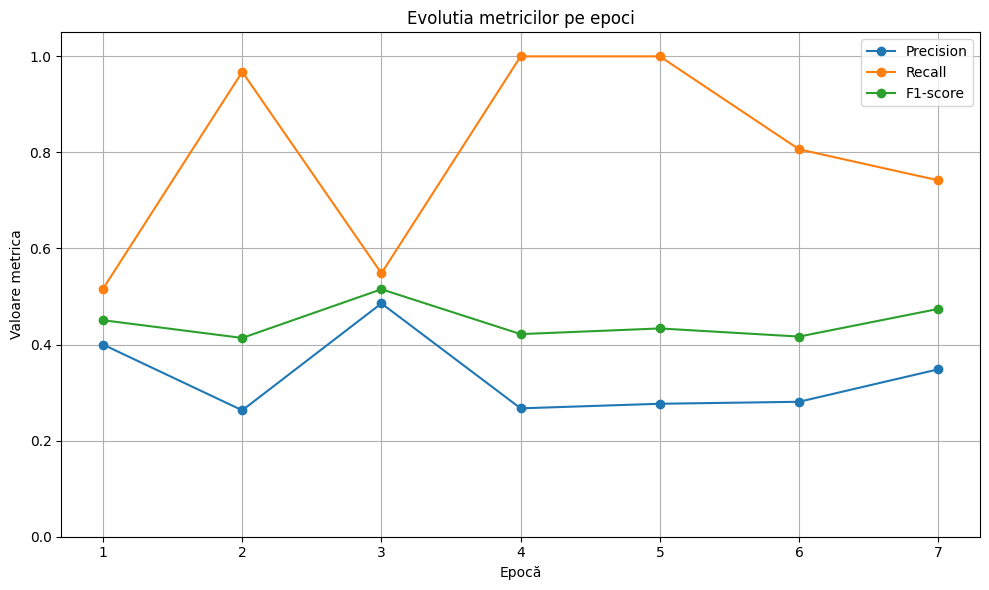

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrice_din_csv(csv_path="epoca_log.csv"):
    if not os.path.exists(csv_path):
        print("CSV-ul nu exista.")
        return

    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 6))
    plt.plot(df["Epoch"], df["Precision"], label="Precision", marker="o")
    plt.plot(df["Epoch"], df["Recall"], label="Recall", marker="o")
    plt.plot(df["Epoch"], df["F1"], label="F1-score", marker="o")

    plt.title("Evolutia metricilor pe epoci")
    plt.xlabel("Epocă")
    plt.ylabel("Valoare metrica")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("evolutie_metrici.png")
    plt.show()

plot_metrice_din_csv()


In [2]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm
from collections import Counter
import csv
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# -------------------CONFIG-------------------------
train_dir = "model"
val_dir = "validare"
batch_size = 16
num_epochs = 10
early_stop_patience = 3
threshold = 0.3  #prag
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#-------------------TRANSFORMARI----------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#---------------------DATE----------------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)

targets = train_dataset.targets
class_counts = [targets.count(0), targets.count(1)]
print("Distributie clase train:", class_counts)

weights = [1.0 / class_counts[t] for t in targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#------------------------MODEL--------------------------------
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=2.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return loss.mean()

loss_fn = FocalLoss(alpha=2.0, gamma=2.0)
optimizer = AdamW(model.parameters(), lr=1e-4)
#---------------------------TRAIN-------------------------
best_recall = 0
epochs_no_improve = 0

with open("fisier_log.csv", mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Epoch", "Precision", "Recall", "F1"])

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix({
                "Loss": f"{running_loss / total:.4f}",
                "Acc": f"{(correct / total) * 100:.2f}%"
            })

        print(f"Epoch {epoch+1}: Train Loss = {running_loss / total:.4f}")

        #---------------------VALIDARE--------------------------
        model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                probs = torch.softmax(outputs, dim=1)[:, 1]  # probabilitate malign
                preds = (probs > threshold).long()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print(f"Epoch {epoch+1} → Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        print("Etichete reale:", Counter(y_true))
        print("Predictii:", Counter(y_pred))
        print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malign"], yticklabels=["Benign", "Malign"])
        plt.xlabel("Predictii")
        plt.ylabel("Etichete reale")
        plt.title(f"Matricea de Confuzie - Epoca {epoch+1}")
        os.makedirs("confusion_matrices", exist_ok=True)
        plt.savefig(f"confusion_matrices/conf_matrix_epoch_{epoch+1}.png")
        plt.close()
        writer.writerow([epoch+1, precision, recall, f1])

        # Early stopping
        if recall > best_recall:
            best_recall = recall
            epochs_no_improve = 0
            output_dir = "resnet50_mamografie_model"
            os.makedirs(output_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(output_dir, "model.pt"))
            print(f"Model salvat in: {output_dir}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping activat. Recall maxim: {best_recall:.4f}")
                break


Distributie clase train: [348, 123]


C:\AI\Incercare proiect AI\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 30/30 [01:36<00:00,  3.23s/it, Loss=0.0179, Acc=74.73%]


Epoch 1: Train Loss = 0.0179
Epoch 1 → Precision: 0.2605 | Recall: 1.0000 | F1: 0.4133
Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
Predictii: Counter({np.int64(1): 119})
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        88
      Malign       0.26      1.00      0.41        31

    accuracy                           0.26       119
   macro avg       0.13      0.50      0.21       119
weighted avg       0.07      0.26      0.11       119


C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\AI\Incercare proiect AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model salvat in: resnet50_mamografie_model


Epoch 2/10: 100%|██████████| 30/30 [01:43<00:00,  3.46s/it, Loss=0.0172, Acc=74.95%]


Epoch 2: Train Loss = 0.0172
Epoch 2 → Precision: 0.2703 | Recall: 0.9677 | F1: 0.4225
Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
Predictii: Counter({np.int64(1): 111, np.int64(0): 8})
              precision    recall  f1-score   support

      Benign       0.88      0.08      0.15        88
      Malign       0.27      0.97      0.42        31

    accuracy                           0.31       119
   macro avg       0.57      0.52      0.28       119
weighted avg       0.72      0.31      0.22       119


Epoch 3/10: 100%|██████████| 30/30 [01:39<00:00,  3.31s/it, Loss=0.0153, Acc=76.65%]


Epoch 3: Train Loss = 0.0153
Epoch 3 → Precision: 0.2718 | Recall: 0.9032 | F1: 0.4179
Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
Predictii: Counter({np.int64(1): 103, np.int64(0): 16})
              precision    recall  f1-score   support

      Benign       0.81      0.15      0.25        88
      Malign       0.27      0.90      0.42        31

    accuracy                           0.34       119
   macro avg       0.54      0.53      0.33       119
weighted avg       0.67      0.34      0.29       119


Epoch 4/10:  93%|█████████▎| 28/30 [01:41<00:07,  3.61s/it, Loss=0.0149, Acc=81.92%]


KeyboardInterrupt: 

In [4]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
from collections import Counter

# ============================ 🔧 CONFIG ============================
train_dir = "model"
val_dir = "validare"
batch_size = 16
num_epochs = 10
early_stop_patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================ 📦 TRANSFORMĂRI ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ============================ 📥 ÎNCĂRCARE DATE ============================
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)

targets = train_dataset.targets
class_counts = [targets.count(0), targets.count(1)]
print("Distribuție clase train:", class_counts)

# Ponderi invers proporționale pentru sampler
weights = [1.0 / class_counts[t] for t in targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ============================ 🧠 MODEL ============================
model = models.resnet50(pretrained=True)

# Înlocuim ultimul fully-connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.to(device)

# ============================ ⚖️ LOSS + OPTIM ============================
# Pondere pentru clasa malign
class_weights = torch.tensor([1.0, class_counts[0] / class_counts[1]], dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=1e-4)

# ============================ 🚦 TRAIN + VALIDARE ============================
best_f1 = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Loss": f"{running_loss / total:.4f}",
            "Acc": f"{(correct / total) * 100:.2f}%"
        })

    print(f"✅ Epoch {epoch+1}: Loss = {running_loss / total:.4f}, Acc = {(correct / total) * 100:.2f}%")

    # VALIDARE
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred)
    print(f"🧪 F1-score: {f1:.4f}")
    print("🎯 Etichete reale:", Counter(y_true))
    print("📊 Predicții:", Counter(y_pred))
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))

    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        output_dir = "resnet50_mamografie_best_now"
        os.makedirs(output_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(output_dir, "model.pt"))
        print(f"💾 Model salvat în: {output_dir}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⏹️ Early stopping activat. F1 maxim: {best_f1:.4f}")
            break


Distribuție clase train: [348, 123]


Epoch 1/10: 100%|██████████| 30/30 [01:53<00:00,  3.79s/it, Loss=0.0316, Acc=59.24%]


✅ Epoch 1: Loss = 0.0316, Acc = 59.24%
🧪 F1-score: 0.4598
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 63, np.int64(1): 56})
              precision    recall  f1-score   support

      Benign       0.83      0.59      0.69        88
      Malign       0.36      0.65      0.46        31

    accuracy                           0.61       119
   macro avg       0.59      0.62      0.57       119
weighted avg       0.70      0.61      0.63       119

💾 Model salvat în: resnet50_mamografie_best_now


Epoch 2/10: 100%|██████████| 30/30 [01:35<00:00,  3.17s/it, Loss=0.0267, Acc=69.21%]


✅ Epoch 2: Loss = 0.0267, Acc = 69.21%
🧪 F1-score: 0.4615
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 73, np.int64(0): 46})
              precision    recall  f1-score   support

      Benign       0.85      0.44      0.58        88
      Malign       0.33      0.77      0.46        31

    accuracy                           0.53       119
   macro avg       0.59      0.61      0.52       119
weighted avg       0.71      0.53      0.55       119

💾 Model salvat în: resnet50_mamografie_best_now


Epoch 3/10: 100%|██████████| 30/30 [02:26<00:00,  4.87s/it, Loss=0.0214, Acc=79.41%]


✅ Epoch 3: Loss = 0.0214, Acc = 79.41%
🧪 F1-score: 0.4317
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 108, np.int64(0): 11})
              precision    recall  f1-score   support

      Benign       0.91      0.11      0.20        88
      Malign       0.28      0.97      0.43        31

    accuracy                           0.34       119
   macro avg       0.59      0.54      0.32       119
weighted avg       0.74      0.34      0.26       119


Epoch 4/10: 100%|██████████| 30/30 [02:02<00:00,  4.07s/it, Loss=0.0216, Acc=81.10%]


✅ Epoch 4: Loss = 0.0216, Acc = 81.10%
🧪 F1-score: 0.5660
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 97, np.int64(1): 22})
              precision    recall  f1-score   support

      Benign       0.84      0.92      0.88        88
      Malign       0.68      0.48      0.57        31

    accuracy                           0.81       119
   macro avg       0.76      0.70      0.72       119
weighted avg       0.80      0.81      0.80       119

💾 Model salvat în: resnet50_mamografie_best_now


Epoch 5/10: 100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Loss=0.0212, Acc=81.95%]


✅ Epoch 5: Loss = 0.0212, Acc = 81.95%
🧪 F1-score: 0.5556
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 96, np.int64(1): 23})
              precision    recall  f1-score   support

      Benign       0.83      0.91      0.87        88
      Malign       0.65      0.48      0.56        31

    accuracy                           0.80       119
   macro avg       0.74      0.70      0.71       119
weighted avg       0.79      0.80      0.79       119


Epoch 6/10: 100%|██████████| 30/30 [01:47<00:00,  3.58s/it, Loss=0.0172, Acc=85.14%]


✅ Epoch 6: Loss = 0.0172, Acc = 85.14%
🧪 F1-score: 0.4375
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 65, np.int64(0): 54})
              precision    recall  f1-score   support

      Benign       0.81      0.50      0.62        88
      Malign       0.32      0.68      0.44        31

    accuracy                           0.55       119
   macro avg       0.57      0.59      0.53       119
weighted avg       0.69      0.55      0.57       119


Epoch 7/10: 100%|██████████| 30/30 [02:41<00:00,  5.38s/it, Loss=0.0131, Acc=89.17%]


✅ Epoch 7: Loss = 0.0131, Acc = 89.17%
🧪 F1-score: 0.5051
🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(1): 68, np.int64(0): 51})
              precision    recall  f1-score   support

      Benign       0.88      0.51      0.65        88
      Malign       0.37      0.81      0.51        31

    accuracy                           0.59       119
   macro avg       0.62      0.66      0.58       119
weighted avg       0.75      0.59      0.61       119

⏹️ Early stopping activat. F1 maxim: 0.5660
